我選擇Spaceship的原因是因為我認為我對機器學習的部分與csv黨的操作並不是很熟悉，所以選擇了一個相較簡單的。
他與Titanic的差別只在於數據量與資料的拆解分析。

Spaceship Titanic 比賽目的是要預測在撞擊異常中有那些旅客會被傳送到另一個宇宙。

他的資料有以下:
    PassengerId:每個乘客的獨特ID，形式是gggg_pp，其中gggg代表乘客是第幾組，而pp為組內的編號。
    HomePlanet:乘客出發的地方
    CryoSleep:乘客有沒有被冷凍睡眠，在冷凍睡眠中的旅客不會離開房間
    Cabin:乘客的房號。形式是deck/num/side，Side又分為P跟S
    Destination:乘客的目的地
    Age:乘客年齡
    VIP:乘客是否為VIP
    RoomService, FoodCourt, ShoppingMall, Spa, VRDeck:乘客在各點消費的金額
    Name:乘客姓名
    Transported:乘客是否被傳送。這欄為要預測的



首先先Import要用的資料庫

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

讀取給予的學習資料

In [257]:
df = pd.read_csv("train.csv")
df.head()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


先移除與欲預測值無關的資料，在此為Name

In [258]:
df.drop('Name',axis=1,inplace=True)

再來要填補缺少的資料
先觀察資料中有幾組數據為空白

In [259]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

可以看到只有PassengerId與Transported是沒有空白資料的，其他都有缺少的資料。
看一下HomePlanet非空白的資料

In [260]:
df['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

可以看到Earth為最多的，所以我們將HomePlanet空白的值都填Earth。

In [261]:
df['HomePlanet'].value_counts().idxmax()
df['HomePlanet'].fillna(df['HomePlanet'].value_counts().idxmax(),inplace=True)
df['HomePlanet'].value_counts().notnull()

Earth     True
Europa    True
Mars      True
Name: HomePlanet, dtype: bool

這樣HomePlanet缺少的資料就填補完了。
但是HomePlanet為地點，數據為Earth、Mars、Europa，這樣沒辦法分析，所以要把它拆成「是否為Earth」、「是否為Europa」、「是否為Mars」

In [262]:
df=pd.get_dummies(data=df,columns=['HomePlanet'])
df.head()

,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,0001_01,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0,1,0
1,0002_01,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,0,0
2,0003_01,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0,1,0
3,0003_02,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0,1,0
4,0004_01,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,0,0


這樣HomePlanet的資料就處理完畢了。
這樣類似HomePlanet的還有Destination，所以我們用一樣的方式去填補其缺少的資料。

In [263]:
df['Destination'].fillna(df['Destination'].value_counts().idxmax(),inplace=True)
df=pd.get_dummies(data=df,columns=['Destination'])

再來我們看到CryoSleep，他的值是簡單的True跟False，
一樣先觀察資料

In [264]:
df['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

然後再將缺少的資料填補為最多值

In [265]:
df['CryoSleep'].fillna(df['CryoSleep'].value_counts().idxmax(),inplace=True)

這樣類似CryoSleep的還有VIP，所以我們用一樣的方式去填補其缺少的資料。

In [266]:
df['VIP'].fillna(df['VIP'].value_counts().idxmax(),inplace=True)

對於Age的資料我們用跟Titanic一樣的方式，用中位數去填補缺少的資料。

In [267]:
df['Age'].fillna(df['Age'].median(),inplace=True)

這樣類似Age的還有以下五筆資料，所以我們用一樣的方式去填補其缺少的資料。

In [268]:
df['RoomService'].fillna(df['RoomService'].median(),inplace=True)
df['FoodCourt'].fillna(df['FoodCourt'].median(),inplace=True)
df['ShoppingMall'].fillna(df['ShoppingMall'].median(),inplace=True)
df['Spa'].fillna(df['Spa'].median(),inplace=True)
df['VRDeck'].fillna(df['VRDeck'].median(),inplace=True)

#df['RoomService']=df.groupby('CryoSleep')['RoomService'].apply(lambda x: x.fillna(x.median()))
#df['FoodCourt']=df.groupby('CryoSleep')['FoodCourt'].apply(lambda x: x.fillna(x.median()))
#df['ShoppingMall']=df.groupby('CryoSleep')['ShoppingMall'].apply(lambda x: x.fillna(x.median()))
#df['Spa']=df.groupby('CryoSleep')['Spa'].apply(lambda x: x.fillna(x.median()))
#df['VRDeck']=df.groupby('CryoSleep')['VRDeck'].apply(lambda x: x.fillna(x.median()))

#df.drop(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis=1,inplace=True)

df.head(20)

,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,False,B/0/P,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0,1,0,0,0,1
1,0002_01,False,F/0/S,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,0,0,0,0,1
2,0003_01,False,A/0/S,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0,1,0,0,0,1
3,0003_02,False,A/0/S,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0,1,0,0,0,1
4,0004_01,False,F/1/S,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,0,0,0,0,1
5,0005_01,False,F/0/P,44.0,False,0.0,483.0,0.0,291.0,0.0,True,1,0,0,0,1,0
6,0006_01,False,F/2/S,26.0,False,42.0,1539.0,3.0,0.0,0.0,True,1,0,0,0,0,1
7,0006_02,True,G/0/S,28.0,False,0.0,0.0,0.0,0.0,0.0,True,1,0,0,0,0,1
8,0007_01,False,F/3/S,35.0,False,0.0,785.0,17.0,216.0,0.0,True,1,0,0,0,0,1
9,0008_01,True,B/1/P,14.0,False,0.0,0.0,0.0,0.0,0.0,True,0,1,0,1,0,0


再看一下缺少的資料，可以看到除了Cabin以外都填補好了。

In [269]:
df.isnull().sum()

PassengerId                    0
CryoSleep                      0
Cabin                        199
Age                            0
VIP                            0
RoomService                    0
FoodCourt                      0
ShoppingMall                   0
Spa                            0
VRDeck                         0
Transported                    0
HomePlanet_Earth               0
HomePlanet_Europa              0
HomePlanet_Mars                0
Destination_55 Cancri e        0
Destination_PSO J318.5-22      0
Destination_TRAPPIST-1e        0
dtype: int64

因為Cabin是由三個資料組合而成的，所以要先拆成三筆資料(三欄)，
用split對"/"拆，就可以得到三筆資料了，
再先移除與欲預測值無關的資料，在此為Cabin跟Num，
將Side的缺少資料用最多者填完後，
最後再將Side拆成P跟S。

In [270]:
df[['Deck', 'Num' , 'Side']] = df.Cabin.str.split("/",expand=True)
df.drop('Cabin',axis=1,inplace=True)
df['Deck'].fillna(df['Deck'].value_counts().idxmax(),inplace=True)
#df=pd.get_dummies(data=df,columns=['Deck'])
df.drop('Deck',axis=1,inplace=True)
df.drop('Num',axis=1,inplace=True)
#df['Num'].fillna(df['Num'].value_counts().idxmax(),inplace=True)
df['Side'].fillna(df['Side'].value_counts().idxmax(),inplace=True)
df=pd.get_dummies(data=df,columns=['Side'])
df.drop('Side_S',axis=1,inplace=True)

最後，我們處裡一下PassengerId，它是由組號與組內編號組成，所以先用split拆成兩筆數據，
再來我們要把組內編號改成組內人數，利用最大編號就是組內人數，
當從後往前看時，如果組內編號大於2，就將下一個同組的人的組內編號改成一樣的，
再移除與欲預測值無關的資料，在此為Cabin跟Num。

In [271]:
df[['RoomId', 'GroupNum']] = df.PassengerId.str.split("_",expand=True)
df[['RoomId','GroupNum']]=df[['RoomId','GroupNum']].astype(str).astype(int)
length = len(df)
for i in range(0,length-1):
    if df['GroupNum'][length-1-i] >= 2:
        df['GroupNum'][df.index[df['RoomId'] == df['RoomId'][length-1-i]]] = df['GroupNum'][length-1-i]
df.drop('RoomId',axis=1,inplace=True)

C:\Users\yoyom\AppData\Local\Temp\ipykernel_18176\369228184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GroupNum'][df.index[df['RoomId'] == df['RoomId'][length-1-i]]] = df['GroupNum'][length-1-i]
C:\Users\yoyom\AppData\Local\Temp\ipykernel_18176\369228184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GroupNum'][df.index[df['RoomId'] == df['RoomId'][length-1-i]]] = df['GroupNum'][length-1-i]
C:\Users\yoyom\AppData\Local\Temp\ipykernel_18176\369228184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

確認都沒有缺少的資料

In [272]:
df.isnull().sum()

PassengerId                  0
CryoSleep                    0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Transported                  0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
Side_P                       0
GroupNum                     0
dtype: int64

這樣所有的數據都處裡完了

In [273]:
df.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Side_P,GroupNum
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0,1,0,0,0,1,1,1
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,0,0,0,0,1,0,1
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0,1,0,0,0,1,0,2
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0,1,0,0,0,1,0,2
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,0,0,0,0,1,0,1


再來準備Training data

In [274]:
df.corr()
X=df.drop(['Transported'],axis=1)
y=df['Transported']

C:\Users\yoyom\AppData\Local\Temp\ipykernel_18176\40417983.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


將資料分為Test跟Train

In [275]:
from sklearn.model_selection import train_test_split
X_train ,X_test ,y_train ,y_test=train_test_split(X,y,test_size=0.3,random_state=67)


跑完學習之後輸出

In [276]:

from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=10000)
lr.fit(X_train,y_train)
predictions=lr.predict(X_test)
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, precision_score
accuracy_score(y_test,predictions)
recall_score(y_test,predictions)
precision_score(y_test,predictions)
pd.DataFrame(confusion_matrix(y_test,predictions),columns=['Predictnot Transported', 'PredictTransported'],index=['Truenot Transported','TrueTransported'])

import joblib
joblib.dump(lr,'Spaceship-LR-20230413.pkl',compress=3)

['Spaceship-LR-20230413.pkl']

In [277]:
accuracy_score(y_test,predictions)

0.781058282208589

In [278]:
recall_score(y_test,predictions)

0.8986280487804879

In [279]:
precision_score(y_test,predictions)

0.7291280148423006

我們用剛剛輸出的機器學習資料來預測

In [280]:
#Model Using
import joblib
model_pretrained = joblib.load('Spaceship-LR-20230413.pkl')

先讀取待預測的資料(Test)
然後將資料處裡成與學習時一樣的資料型態。

In [281]:
#forsubmission
df_test=pd.read_csv("test.csv")
df_test.drop(['Name'],axis=1,inplace=True)
df_test['HomePlanet'].fillna(df_test['HomePlanet'].value_counts().idxmax(),inplace=True)
df_test=pd.get_dummies(data=df_test,columns=['HomePlanet'])
df_test['Destination'].fillna(df_test['Destination'].value_counts().idxmax(),inplace=True)
df_test=pd.get_dummies(data=df_test,columns=['Destination'])
df_test['CryoSleep'].fillna(df_test['CryoSleep'].value_counts().idxmax(),inplace=True)
df_test['VIP'].fillna(df_test['VIP'].value_counts().idxmax(),inplace=True)
df_test['Age'].fillna(df_test['Age'].median(),inplace=True)

df_test['RoomService'].fillna(df_test['RoomService'].median(),inplace=True)
df_test['FoodCourt'].fillna(df_test['FoodCourt'].median(),inplace=True)
df_test['ShoppingMall'].fillna(df_test['ShoppingMall'].median(),inplace=True)
df_test['Spa'].fillna(df_test['Spa'].median(),inplace=True)
df_test['VRDeck'].fillna(df_test['VRDeck'].median(),inplace=True)

#df_test['RoomService']=df_test.groupby('CryoSleep')['RoomService'].apply(lambda x: x.fillna(x.median()))
#df_test['FoodCourt']=df_test.groupby('CryoSleep')['FoodCourt'].apply(lambda x: x.fillna(x.median()))
#df_test['ShoppingMall']=df_test.groupby('CryoSleep')['ShoppingMall'].apply(lambda x: x.fillna(x.median()))
#df_test['Spa']=df_test.groupby('CryoSleep')['Spa'].apply(lambda x: x.fillna(x.median()))
#df_test['VRDeck']=df_test.groupby('CryoSleep')['VRDeck'].apply(lambda x: x.fillna(x.median()))

#df_test.drop(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis=1,inplace=True)

df_test[['Deck', 'Num' , 'Side']] = df_test.Cabin.str.split("/",expand=True)
df_test.drop('Cabin',axis=1,inplace=True)

df_test['Deck'].fillna(df_test['Deck'].value_counts().idxmax(),inplace=True)
#df_test=pd.get_dummies(data=df_test,columns=['Deck'])
df_test.drop('Deck',axis=1,inplace=True)

df_test.drop('Num',axis=1,inplace=True)
#df['Num'].fillna(df['Num'].value_counts().idxmax(),inplace=True)
df_test['Side'].fillna(df_test['Side'].value_counts().idxmax(),inplace=True)
df_test=pd.get_dummies(data=df_test,columns=['Side'])
df_test.drop('Side_S',axis=1,inplace=True)

df_test[['RoomId', 'GroupNum']] = df_test.PassengerId.str.split("_",expand=True)
df_test[['RoomId','GroupNum']]=df_test[['RoomId','GroupNum']].astype(str).astype(int)
length = len(df_test)
for i in range(0,length-1):
    if df_test['GroupNum'][length-1-i] >= 2:
        df_test['GroupNum'][df_test.index[df_test['RoomId'] == df_test['RoomId'][length-1-i]]] = df_test['GroupNum'][length-1-i]
df_test.drop('RoomId',axis=1,inplace=True)

C:\Users\yoyom\AppData\Local\Temp\ipykernel_18176\1762326173.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['GroupNum'][df_test.index[df_test['RoomId'] == df_test['RoomId'][length-1-i]]] = df_test['GroupNum'][length-1-i]
C:\Users\yoyom\AppData\Local\Temp\ipykernel_18176\1762326173.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['GroupNum'][df_test.index[df_test['RoomId'] == df_test['RoomId'][length-1-i]]] = df_test['GroupNum'][length-1-i]
C:\Users\yoyom\AppData\Local\Temp\ipykernel_18176\1762326173.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

可以看到他的資料已經是一樣的格式了

In [282]:
df_test.head(20)

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Side_P,GroupNum
0,0013_01,True,27.0,False,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,1
1,0018_01,False,19.0,False,0.0,9.0,0.0,2823.0,0.0,1,0,0,0,0,1,0,1
2,0019_01,True,31.0,False,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,0,1
3,0021_01,False,38.0,False,0.0,6652.0,0.0,181.0,585.0,0,1,0,0,0,1,0,1
4,0023_01,False,20.0,False,10.0,0.0,635.0,0.0,0.0,1,0,0,0,0,1,0,1
5,0027_01,False,31.0,False,0.0,1615.0,263.0,113.0,60.0,1,0,0,0,0,1,1,1
6,0029_01,True,21.0,False,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,1,1
7,0032_01,True,20.0,False,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,2
8,0032_02,True,23.0,False,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,0,2
9,0033_01,False,24.0,False,0.0,639.0,0.0,0.0,0.0,1,0,0,1,0,0,0,1


因為在Submission時只要PassengerId與Transported，
我們將預測結果輸出成要求的格式，再將其輸出成csv檔，就可以去繳交了

In [283]:

predictions2=model_pretrained.predict(df_test)
#Prearesubmitfile
forSubmissionDF=pd.DataFrame(columns=['PassengerId','Transported'])
forSubmissionDF['PassengerId']=df_test['PassengerId']
forSubmissionDF['Transported']=predictions2
forSubmissionDF

forSubmissionDF.to_csv('for_submission_20230417.csv', index=False)


這個比賽做起來就是Titanic的延伸，幾乎都是用Titanic用過的，只需要在那基礎下再去熟悉操作，再加入Split的部分，觀察那些數據要如何處裡，就大致完成了

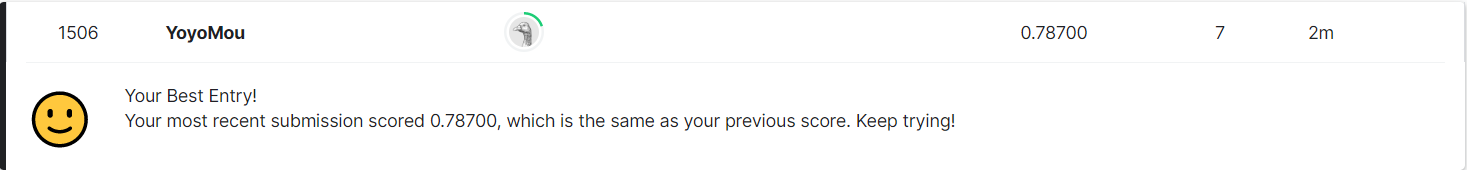

我最終的結果最好的成績是0.787，排名1506。


可能改善(改變)的地方:
    1.將中位數改成平均數
    2.CryoSleep的人不會有消費，所以在消費的數據填補用CryoSleep做分類
    3.(未做)有消費的人都不會有CryoSleep，所以如果那五組消費的不為0，CryoSleep為False。

之後我又做了一些嘗試，以下為結果:
1.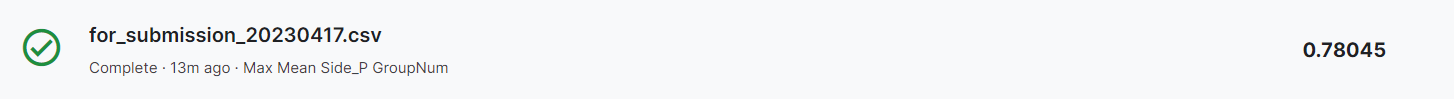
2.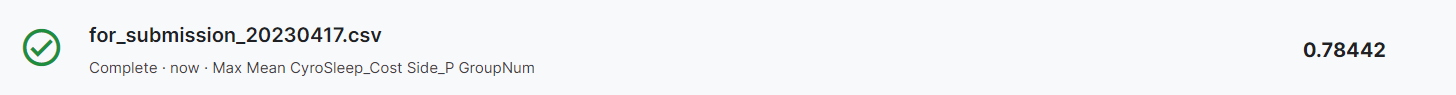